In [1]:
#NDWI load packages

import datacube

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb



In [2]:
# Import tools to mask data for cloud

import scipy.ndimage
import xarray
import numpy
import datacube
from datacube.utils.masking import make_mask
from datacube.utils.masking import mask_invalid_data
from odc.algo import mask_cleanup

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import rgb


import rasterio
import xarray as xr

In [3]:
# connect to datacube

dc = datacube.Datacube(app="07_Parallel_processing_with_Dask")

In [4]:
#Enable Dask

client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/akjournalism@gmail.com/proxy/8787/status,
Dashboard: /user/akjournalism@gmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45515,Workers: 1
Dashboard: /user/akjournalism@gmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:42081,Total threads: 2
Dashboard: /user/akjournalism@gmail.com/proxy/42941/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:41979,


In [5]:
# Lazy load data LANDSAT

lazy_ds_Land = dc.load(product=["ga_ls8c_ard_3",
                  "ga_ls9c_ard_3"],
                  measurements=["nbart_green", "nbart_swir_2", "oa_fmask"],
                  x=(149.64, 149.94),
                  y=(-37.00, -37.2),
                  time=('2020-02-08', '2020-03-10'),
                  dask_chunks={"time": 1, "x": 2048, "y": 2048})
resampling={
                   "fmask": "nearest",
                   "*": "bilinear"
               },


lazy_ds_Land

<xarray.Dataset>
Dimensions:       (time: 6, y: 855, x: 986)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-0...
  * y             (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x             (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    oa_fmask      (time, y, x) uint8 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [6]:
# Lazy load data SENTINEL

lazy_ds_Sent = dc.load(product=["'ga_s2am_ard_3", "ga_s2bm_ard_3"],
                  measurements=["nbart_green", "nbart_swir_2", "oa_fmask"],
                  x=(149.64, 149.94),
                  y=(-37.2, -37.00),
                  time=('2020-02-08', '2020-03-10'),
                  resolution=(-30, 30),
                  dask_chunks={"time": 1, "x": 2048, "y": 2048})
resampling={
                   "fmask": "nearest",
                   "*": "bilinear"
               },
    
  
lazy_ds_Sent

<xarray.Dataset>
Dimensions:       (time: 6, y: 855, x: 986)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-14T00:06:52.104184 ... 2020-0...
  * y             (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x             (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    oa_fmask      (time, y, x) uint8 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [7]:
# Merge XArrays

import xarray as xr
import pandas as pd


# Merge the XArrays
merged_xarr = xr.concat([lazy_ds_Land, lazy_ds_Sent], dim='time',)


# Print the merged XArray
print(merged_xarr)

#merged_dim = 2 below could be a problem

<xarray.Dataset>
Dimensions:       (time: 12, y: 855, x: 986)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-0...
  * y             (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x             (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    oa_fmask      (time, y, x) uint8 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


In [8]:
# app

dc = datacube.Datacube(app="Masking_data")

# flags

merged_xarr.oa_fmask.attrs["flags_definition"]

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

In [9]:

merged_xarr.oa_fmask


<xarray.DataArray 'oa_fmask' (time: 12, y: 855, x: 986)>
dask.array<concatenate, shape=(12, 855, 986), dtype=uint8, chunksize=(1, 855, 986), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-03...
  * y            (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x            (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref  int32 3577
Attributes:
    units:             1
    nodata:            0
    flags_definition:  {'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'values':...
    crs:               EPSG:3577
    grid_mapping:      spatial_ref

In [10]:
dataset = xr.Dataset(merged_xarr)

In [11]:
merged_xarr


<xarray.Dataset>
Dimensions:       (time: 12, y: 855, x: 986)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-0...
  * y             (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x             (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    oa_fmask      (time, y, x) uint8 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [12]:
import numpy as np
import dask.array as da

def make_mask(variable, **flags):
    mask = da.zeros_like(variable, dtype=bool)
    mask_value = True

    for flag_name, flag_value in flags.items():
        mask |= variable == flag_value

    return mask == mask_value

In [13]:
# Create the mask based on "valid" pixels

clear_mask = make_mask(merged_xarr.oa_fmask, fmask="valid")

# Apply the mask

clear = merged_xarr.where(clear_mask)


In [ ]:
# Plot
#clear_mask.plot(col="time", col_wrap=4)

In [14]:
# Identify pixels that are either "valid", "water" or "snow"

cloud_free_mask = (
    make_mask(merged_xarr.oa_fmask, fmask="valid") | 
    make_mask(merged_xarr.oa_fmask, fmask="water") | 
    make_mask(merged_xarr.oa_fmask, fmask="snow")
)

# Apply the mask
cloud_free = merged_xarr.where(cloud_free_mask)

In [15]:
# Set invalid nodata pixels to NaN

valid_data = merged_xarr.oa_fmask.plot
valid_data

# Identify pixels that are either "cloud" or "cloud_shadow"

cloud_shadow_mask = (
    make_mask(merged_xarr.oa_fmask, fmask="cloud") | 
    make_mask(merged_xarr.oa_fmask, fmask="shadow")
)

In [ ]:
# Plot cloud shadow mask

#cloud_shadow_mask.plot(col="time", col_wrap=4)

In [16]:
# Dilate all cloud and cloud shadow pixels by 5 pixels in all directions

cloud_shadow_buffered = mask_cleanup(mask=cloud_shadow_mask,
                                     mask_filters=[("dilation", 5)])

In [ ]:
# Plot cloud shadow buffered

#cloud_shadow_buffered.plot(col="time", col_wrap=4)

In [17]:
# Apply the mask

buffered_cloud_free = merged_xarr.where(~cloud_shadow_buffered)

# Set invalid nodata pixels to NaN

valid_data = mask_invalid_data(buffered_cloud_free)

valid_data

<xarray.Dataset>
Dimensions:       (time: 12, y: 855, x: 986)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-0...
  * y             (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x             (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) float64 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float64 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    oa_fmask      (time, y, x) float64 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
#obs_pixels_count = valid_data.count(dim='time', skipnan=True)
#import numpy as np

#def count_nan_values(array):
    nan_count = np.isnan(valid_data).sum(dim = time) 
    return nan_count

# Count NaN values in the array
#nan_count = count_nan_values(valid_data)
print("Number of NaN values:", nan_count)

In [ ]:
#nan_count

In [ ]:
#nan_count.attrs = valid_data.attrs

In [18]:
# calc mNDWI

band_diff = valid_data.nbart_green - valid_data.nbart_swir_2
band_sum = valid_data.nbart_green + valid_data.nbart_swir_2

valid_data["mndwi"] = band_diff / band_sum

valid_data

<xarray.Dataset>
Dimensions:       (time: 12, y: 855, x: 986)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-0...
  * y             (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x             (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) float64 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float64 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    oa_fmask      (time, y, x) float64 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
    mndwi         (time, y, x) float64 dask.array<chunksize=(1, 855, 986), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
## MAYBE APLLY MASKS TO DATA SET AGAIN AFTER CALLING INSTEAD OF DELETING 
#TRY NAN HERE
#no_nan = valid_data.where(buffered_cloud_free, cloud_shadow_buffered, cloud_free, clear_mask)
# del buffered_cloud_free, cloud_shadow_buffered, cloud_free, clear_mask

In [19]:
# Call lazy data XArray from Dask 

mndwi_load = valid_data.mndwi.load()
mndwi_load

<xarray.DataArray 'mndwi' (time: 12, y: 855, x: 986)>
array([[[        nan,         nan,         nan, ...,  0.11853502,
          0.12001743,  0.11890062],
        [        nan,         nan,         nan, ...,  0.13830286,
          0.12950655,  0.12493018],
        [        nan,         nan,  0.37323329, ...,  0.14349593,
          0.14349593,  0.13639761],
        ...,
        [ 0.17394261,  0.19848771,  0.19563615, ...,  0.19274072,
          0.19113667,  0.18880623],
        [ 0.16753577,  0.18542686,  0.18684064, ...,  0.19734378,
          0.19292334,  0.18938862],
        [ 0.16168582,  0.16864295,  0.17348186, ...,  0.2003965 ,
          0.19460973,  0.1911952 ]],

       [[        nan,         nan,         nan, ...,  0.57608696,
          0.54945055,  0.52985075],
        [        nan,         nan,         nan, ...,  0.52362949,
          0.51297405,  0.52986513],
        [        nan,         nan,         nan, ...,  0.49034749,
          0.4619883 ,  0.50204082],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.66740873,  0.66696997,  0.66693447, ...,  0.71009805,
          0.70761867,  0.70715706],
        [ 0.66798942,  0.66700462,  0.66624555, ...,  0.70895522,
          0.70968703,  0.71054199],
        [ 0.66795452,  0.6658504 ,  0.66488939, ...,  0.71028498,
          0.70916529,  0.71130331]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-03...
  * y            (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x            (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref  int32 3577

In [ ]:
#obs_pixels_count = valid_data.count(dim='time', skipnan=True)
#import numpy as np

#def count_nan_values(mndwi_load):
    #nan_count = np.isnan(mndwi_load).sum()
    #return nan_count

# Count NaN values in the array
#nan_count = count_nan_values(mndwi_load)
#print("Number of NaN values:", nan_count)

In [ ]:
#nan_count

In [ ]:
# plot data 

#mndwi_load.plot()

# Display the plot
#plt.show()

# mndwi_load.mndwi.plot(col='time', col_wrap=5)

#import xarray as xr
#import matplotlib.pyplot as plt

# Assuming you have a dataset named 'ds' with a variable named 'variable1'
# Access the variable and plot it
#mndwi_load['mndwi'].plot()

# Display the plot
#plt.show()

In [ ]:
#ds_ignorenan

In [ ]:
#remove nan before calc - what if we made it a reallllly big number so it stands out.... 

In [20]:
valid_data.mndwi

<xarray.DataArray 'mndwi' (time: 12, y: 855, x: 986)>
array([[[        nan,         nan,         nan, ...,  0.11853502,
          0.12001743,  0.11890062],
        [        nan,         nan,         nan, ...,  0.13830286,
          0.12950655,  0.12493018],
        [        nan,         nan,  0.37323329, ...,  0.14349593,
          0.14349593,  0.13639761],
        ...,
        [ 0.17394261,  0.19848771,  0.19563615, ...,  0.19274072,
          0.19113667,  0.18880623],
        [ 0.16753577,  0.18542686,  0.18684064, ...,  0.19734378,
          0.19292334,  0.18938862],
        [ 0.16168582,  0.16864295,  0.17348186, ...,  0.2003965 ,
          0.19460973,  0.1911952 ]],

       [[        nan,         nan,         nan, ...,  0.57608696,
          0.54945055,  0.52985075],
        [        nan,         nan,         nan, ...,  0.52362949,
          0.51297405,  0.52986513],
        [        nan,         nan,         nan, ...,  0.49034749,
          0.4619883 ,  0.50204082],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.66740873,  0.66696997,  0.66693447, ...,  0.71009805,
          0.70761867,  0.70715706],
        [ 0.66798942,  0.66700462,  0.66624555, ...,  0.70895522,
          0.70968703,  0.71054199],
        [ 0.66795452,  0.6658504 ,  0.66488939, ...,  0.71028498,
          0.70916529,  0.71130331]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-03...
  * y            (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x            (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref  int32 3577

In [22]:
# Extract the NDWI data variable COULD BE WRONG WORKS WITHOUT
ndwi_variable = valid_data.mndwi

threshold = 0.3  # Adjust as per your requirement

# Create a boolean array with null, true, and false values
bool_data = xr.where(np.isnan(ndwi_variable), np.nan, ndwi_variable > threshold)

# Create an Xarray DataArray from the boolean array
#bool_3 = xr.DataArray(bool_data, dims=('x', 'y'))



# Create a binary water or no water raster
#binary_data = ndwi_variable > threshold if == (nan) leave it nan) 3 LEVEL bOOLEAN

#binary_data = binary_date.dtype('uint8')

In [24]:
bool_data.attrs = valid_data.attrs

In [25]:
bool_data

<xarray.DataArray 'mndwi' (time: 12, y: 855, x: 986)>
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan,  1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-02-10T23:44:57.745417 ... 2020-03...
  * y            (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x            (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref  int32 3577
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [26]:
# Calculate total wetness through time
wet_pixels_sum = bool_data.sum(dim=['time'])

In [27]:
wet_pixels_sum.attrs = valid_data.attrs

In [28]:
wet_pixels_sum

<xarray.DataArray 'mndwi' (y: 855, x: 986)>
array([[2., 2., 2., ..., 6., 6., 6.],
       [2., 2., 2., ..., 6., 6., 6.],
       [2., 2., 3., ..., 6., 6., 6.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])
Coordinates:
  * y            (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x            (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref  int32 3577
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [29]:
# Calculate total count wet pixels **** CHECK WORKS ****
wet_pixels_count = bool_data.count(dim=['time'])

#wet_pixels_count

In [30]:
#et_pixels_count.attrs = valid_data.attrs

wet_pixels_count

<xarray.DataArray 'mndwi' (y: 855, x: 986)>
array([[6, 6, 6, ..., 9, 9, 9],
       [6, 6, 6, ..., 9, 9, 9],
       [6, 6, 7, ..., 9, 9, 9],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]])
Coordinates:
  * y            (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x            (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref  int32 3577

In [32]:
wet_pixels = wet_pixels_sum/wet_pixels_count

In [33]:
wet_pixels.attrs = valid_data.attrs

In [34]:
wet_pixels

<xarray.DataArray 'mndwi' (y: 855, x: 986)>
array([[0.33333333, 0.33333333, 0.33333333, ..., 0.66666667, 0.66666667,
        0.66666667],
       [0.33333333, 0.33333333, 0.33333333, ..., 0.66666667, 0.66666667,
        0.66666667],
       [0.33333333, 0.33333333, 0.42857143, ..., 0.66666667, 0.66666667,
        0.66666667],
       ...,
       [0.28571429, 0.28571429, 0.28571429, ..., 0.28571429, 0.28571429,
        0.28571429],
       [0.28571429, 0.28571429, 0.28571429, ..., 0.28571429, 0.28571429,
        0.28571429],
       [0.28571429, 0.28571429, 0.28571429, ..., 0.28571429, 0.28571429,
        0.28571429]])
Coordinates:
  * y            (y) float64 -4.153e+06 -4.153e+06 ... -4.178e+06 -4.178e+06
  * x            (x) float64 1.567e+06 1.567e+06 ... 1.597e+06 1.597e+06
    spatial_ref  int32 3577
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

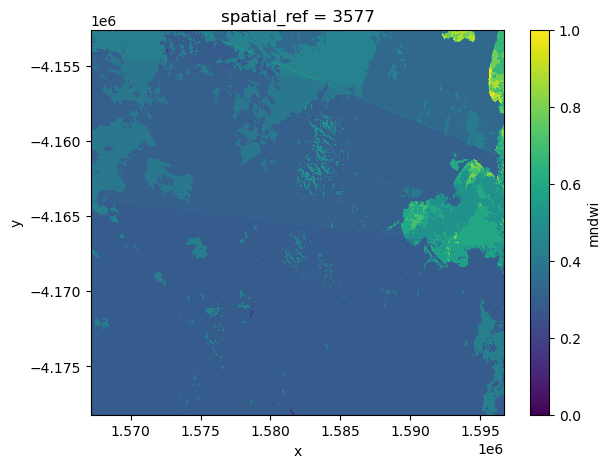

In [35]:
#not necessary
wet_pixels.plot(size=5,)

In [36]:
#wet_pixels = wo.isel(time=-0).to_array()

from datacube.utils.cog import write_cog

write_cog (geo_im=wet_pixels,
          fname='./test_wet_pixels_1.tif',
          overwrite=True)

PosixPath('test_wet_pixels_1.tif')

In [ ]:
#CLOSE DASK

client.close()

# delete stored objects

del valid_data, wet_pixels
